# imports

In [1]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import data_transforations as data_tr

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

import joblib

## Models

In [2]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import loguniform

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from imblearn.ensemble import BalancedRandomForestClassifier

from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight



## Scoring

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Functions

In [4]:
#grouping lead_provider_name into less granular categories
def lead_prov_grouping(prov):
    if prov in ['Recycled Freemium', 'SPL-Freemium', 'Sold Freemium','Quoted Freemium', 'ABBY Freemium', 'Freemium','CellC-Freemium']:
        return 'Freemium'
    elif prov in ['LeadWarming', 'LeadWarming TN ', 'Lead Warming']:
        return 'LeadWarming'
    elif prov in ['BLDS 101', 'BLDS']:
        return 'BLDS'
    elif prov in ['SD Phone Leads','MWL Phone Leads', 'iTalk External Call Center']:
        return 'Phone leads'
    elif prov in ['Sanlam Direct Cape Referral', 'SDC-Referral', 'MWL Referrals']:
        return 'Refferals'
    elif prov in ['Website',  'Bing', 'SD Web','MWL Web', 'Sanlam Digital','GoogleDisplay','GoogleSearch']:
        return 'Web'
    elif prov in ['MiWayLife', 'Sure_Strat_MWL','Existing Client','Reach_Republic_MWL', 'Newsletter']:
        return 'MWL'
    elif prov in ['Lead-D365-Production', 'Sanlam-Lead-D365-Production']:
        return 'D365'
    elif prov in ['Recycled','Facebook', 'Reinstatement', 'Vicidial','Wills', 'Affiliate', 'Sanlam Direct Cape', 'LiveLeads','SEO',
       'Competitions', 'SDC HIV','Olico']:
        return 'Other'
    else:
        return 'Other'


In [5]:
def data_prep(data,target,features=[],filter=None,column_excl = ['3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag', 'policy_name'],cat_cols=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class',
       'lead_provider_groups', 'lead_type', 'sales_channel','hiv_group', 'securitygroup_id', 'age_band',
       'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band','underwriting_outcome'],imp_dict={'optionality': 'mode','cover_amount_full':'mean'}):

    if filter is not None:
        data = data[data[filter].notnull()].copy() 
                #for annual lapse, only policies older than 11 months have a flag, 
                        #thus excluding missing values for anniversary lapse flag excludes the policies younger than 11 months

    #imputing nulls
    df=DataPreparation(df=data)
    df.imputating_nulls(imp_dict=imp_dict)
    data=df.imputed_df.copy()

    #grouping lead-provider_name
    data['lead_provider_groups']= data['lead_provider_name'].apply(lead_prov_grouping)
    data.drop(columns=['lead_provider_name'],inplace=True)
    cat_cols.append('lead_provider_groups')

    #hot-one encoding categorical features
    data=pd.get_dummies(data,columns=cat_cols, dtype=int)
    if features == []:
        cols=set(data.columns)
        features=list(cols.difference(column_excl))

    #split data and target     
    X = data[features].copy()
    Y = data[target].astype(int).copy()
    
    # Train Test Split
    X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

    return X_train, X_test, Y_train, y_test


In [6]:
#custom score for models
from sklearn.metrics import make_scorer
def my_custom_accuracy(y_true, y_pred):
    w=2
    cm = confusion_matrix(y_true, y_pred)
    true_0 =(cm[0][0]/(cm[0][0]+cm[0][1]))
    true_1= w*(cm[1][1]/(cm[1][1]+cm[1][0]))

    return (true_0+true_1)/(1+w)
custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)

# Training Data

In [7]:
path="C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/Data2/"
data=pd.DataFrame(pd.read_csv(path+"inception_data_eco_v3.csv"))
data=data.drop(columns=['Unnamed: 0','occupation','campaign_name','hiv_group'])
data_info=DataPreparation(df=data)
display(data_info.null_df)

,nulls,percentage nulls
policy_name,0,0.000000
age,0,0.000000
education,0,0.000000
gender,0,0.000000
income,0,0.000000
smoker_status,0,0.000000
sold_socio_economic_class,0,0.000000
occupation_class,0,0.000000
lead_provider_name,0,0.000000
lead_type,0,0.000000


In [8]:
#scaling numerical, countinous features

scale = StandardScaler()
data_s=data.copy()
column_scale=[ 'age',  'income',  'eml','pml',  'benefits_count',
       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
       'funeral_count', 'original_premium', 'duration_policy_start_delay',
       '# calls', '# calls contacted', 'res_code_QA_sum',
       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum','inflation', 'unemployment rate']
data_s[column_scale] = scale.fit_transform(data_s[column_scale])

 #columns to be hot-one encoded
categorical_cols=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class',
       'lead_type', 'optionality', 'hiv_test_required', 'age_band',
        'original_premium_band']

 #columns with nulls to be imputed and the method of imputation
impt_dict={'optionality': 'mode','cover_amount_full':'mean'}

# Lapses within 3 Months

XGBoost classification model with SMOTE resampling

## Training

In [9]:
target='3month_lapse'
print('target ratios: ',data[target].sum()*100/data[target].count())

#dropping unimportant features
data_s.drop(columns=['underwriting_outcome','securitygroup_id','sales_channel',
 'age', 'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium'],inplace=True)


#split data into training and test sets
X_train,x_test, Y_train, y_test = data_prep(data_s,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=categorical_cols)


#apply SMOTE resampling
sm = SMOTE(sampling_strategy=0.4,random_state=42)
X_smote, Y_smote = sm.fit_resample(X_train.copy(), Y_train.copy())
print('smote resampling target ratio: ',Y_smote.sum()*100/Y_smote.count())

target ratios:  19.873746418338108
smote resampling target ratio:  28.568577558249764


In [10]:
X_train_n=X_smote.copy()
Y_train_n=Y_smote.copy()
scorer=custom_scorer

#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)


In [11]:
joblib.dump(xgbc, '3month_lapse_model.joblib')

['3month_lapse_model.joblib']

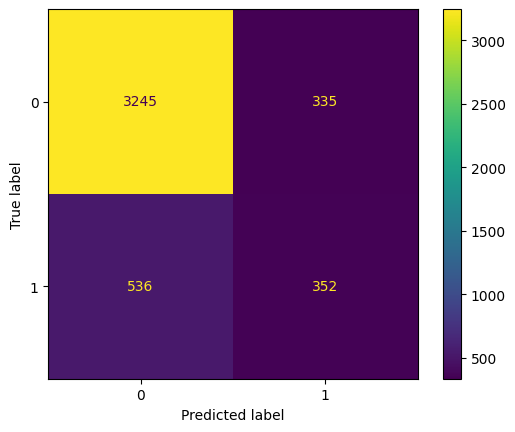

In [12]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

## Model for scoring

In [13]:
new_data = x_test.copy()
model_file='3month_lapse_model.joblib'
m3_model = joblib.load(model_file)
m3_prediction = m3_model.predict(new_data)

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


NotFittedError: This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
m3_prediction

# Lapses within 6 months

XGBoost classifier

## Training

In [ ]:
target='6month_lapse'
print('target ratios: ',data[target].sum()*100/data[target].count())

#dropping unimportant features
data_s.drop(columns=['underwriting_outcome','securitygroup_id','sales_channel',
 'age', 'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium'],inplace=True)



#split data into training and test sets
X_train,x_test, Y_train, y_test = data_prep(data_s,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=categorical_cols)



In [ ]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()

scorer=custom_scorer
#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)


In [ ]:
joblib.dump(xgbc, '6month_lapse_model.joblib')

In [ ]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

## Model for scoring

In [ ]:
new_data = x_test.copy()
model_file='6month_lapse_model.joblib'
m6_model = joblib.load(model_file)
m6_prediction = m6_model.predict(new_data)

In [ ]:
m6_prediction

# Lapses within 1 year

XGBoost classifier

## Training

In [ ]:
target='1yr_lapse'
print('target ratios: ',data[target].sum()*100/data[target].count())

#dropping unimportant features
data_s.drop(columns=['underwriting_outcome','securitygroup_id','sales_channel',
 'age', 'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium'],inplace=True)


#split data into training and test sets
X_train,x_test, Y_train, y_test = data_prep(data_s,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=categorical_cols)




In [ ]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()

scorer=custom_scorer
#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)


In [ ]:
joblib.dump(xgbc, '1year_lapse_model.joblib')

In [ ]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

## Model for scoring

In [ ]:
new_data = x_test.copy()
model_file='1year_lapse_model.joblib'
y1_model = joblib.load(model_file)
y1_prediction = y1_model.predict(new_data)

In [ ]:
y1_prediction

# Lapses

XGBoost classifier model

## Training

In [ ]:
target='lapse_flag'
print('target ratios: ',data[target].sum()*100/data[target].count())

#dropping unimportant features
data_s.drop(columns=['underwriting_outcome','securitygroup_id','sales_channel',
 'age', 'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium'],inplace=True)


#split data into training and test sets
X_train,x_test, Y_train, y_test = data_prep(data_s,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=categorical_cols)




In [ ]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()

scorer=custom_scorer
#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)


In [ ]:
joblib.dump(xgbc, 'lapse_model.joblib')

In [ ]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

## Model for scoring

In [ ]:
new_data = x_test.copy()
model_file='lapse_model.joblib'
lapse_model = joblib.load(model_file)
lapse_prediction = lapse_model.predict(new_data)

In [ ]:
lapse_prediction

# Anniversary lapses

XGBoost classifier model with SMOTE resampled data

## Training

In [ ]:
target='ann_lapse'
print('target ratios: ',data[target].sum()*100/data[target].count())

#dropping unimportant features
data_s.drop(columns=['underwriting_outcome','securitygroup_id','sales_channel',
 'age', 'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium'],inplace=True)


#split data into training and test sets
X_train,x_test, Y_train, y_test = data_prep(data_s,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=categorical_cols,filter='ann_lapse')

#apply SMOTE resampling
sm = SMOTE(sampling_strategy=0.6,random_state=42)
X_smote, Y_smote = sm.fit_resample(X_train.copy(), Y_train.copy())
print('smote resampling target ratio: ',Y_smote.sum()*100/Y_smote.count())


In [ ]:
X_train_n=X_smote.copy()
Y_train_n=Y_smote.copy()

scorer=custom_scorer
#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

In [ ]:
joblib.dump(xgbc, 'ann_lapse_model.joblib')

In [ ]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

## Model for scoring

In [ ]:
new_data = x_test.copy()
model_file='ann_lapse_model.joblib'
ann_lapse_model = joblib.load(model_file)
ann_lapse_prediction = ann_lapse_model.predict(new_data)

In [ ]:
lapse_prediction

# Using Enriched Data